# A mini Machine Learning Project exploring feature and model selection

This code will:    
- Loads the data    
- Performs feature and model selection (one table and two visualizations to present these results)

In [1]:
# Loading all needed library

from scipy.io import arff
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, cross_val_score
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import Imputer
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [2]:
# Importing data
df = pd.read_csv("../data/data_clean.csv")

# Take a glance at the dataset:
df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,bankrupt
0,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.1225,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,0
1,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.1721,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,0
2,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.9881,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,0
3,0.024526,0.43236,0.27546,1.7833,-10.1050,0.56944,0.024526,1.3057,1.0509,0.56453,...,0.048398,0.043445,0.95160,0.142980,4.2286,5.0528,98.783,3.6950,3.4844,0
4,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.4094,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,0


## Feature and model selection

This dataset has a few missing values so I will need to do some preprocessing to impute the missing values with the mean of each features. This is not an ideal way but it won't affect the result much since the number of missing values is relatively small (less than 10% for each feature that has missing values).

In [3]:
# Divide the dataset into traning and testing set with labels
X = df.iloc[:,:-1].values
y = df.iloc[:,63].values

# splitting the set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)
y_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [4]:
#  Imputing the missing values by the mean of the columns
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X_train)

X = imp.transform(X)

# Split again:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

### 1st try out: Logistic Regression


In [5]:
# Setting up
threshold = 1e-6

# Logistic Regression with L1 penalty
clf1 = LogisticRegression(penalty = 'l1')
# Logistic Regression with L1 penalty
clf2 = LogisticRegression(penalty = 'l2')

In [6]:
model_list = (clf1, clf2)

for clf in model_list:
    clf.fit(X_train, y_train)
    feature_weight = clf.coef_
    print("The validation score of model",clf.score(X_test,y_test))
    print("The number of selected feature of model",(np.sum(abs(feature_weight) > threshold)))

The validation score of model 0.953355544979
The number of selected feature of model 52
The validation score of model 0.938124702523
The number of selected feature of model 55


Out of 64 features, the first model chooses 54 features with higher validation score ($0.95$), so we will choose this model. Now I will perform a cross validation to find the best hyperparameter 'C':

In [7]:
listC = 10.0**np.arange(-4,4)
parameter = {'C':listC}
lr = LogisticRegression(penalty = 'l1')
clf = GridSearchCV(lr, parameter)

clf.fit(X_train, y_train)
print("The best parameter is",clf.best_params_)
print("The best score is",clf.best_score_)

The best parameter is {'C': 0.001}
The best score is 0.951440133302


In [8]:
lr = LogisticRegression(penalty = 'l1', C = 0.001)
lr.fit(X_train, y_train)
print("Training score of Logistic Regression model is",lr.score(X_train, y_train))
print("Testing score of Logistic Regression model is",lr.score(X_test, y_test))

Training score of Logistic Regression model is 0.952035229707
Testing score of Logistic Regression model is 0.955259400286


### 2nd try out: Decision Tree Classifier

I will combine the average 10-fold cross-validation scores on the training dataset using sklearn's cross_val_score and the Decision Tree Classifier as the model to find the best estimator for the dataset

In [ ]:
maxDepth = 50
kFold = 10
scores = np.zeros((maxDepth, kFold))

for depth in np.arange(1, maxDepth + 1):
    clf = DecisionTreeClassifier(max_depth=depth)
    scores[depth - 1] = cross_val_score(clf, X_train, 
                                        y_train, cv=kFold)

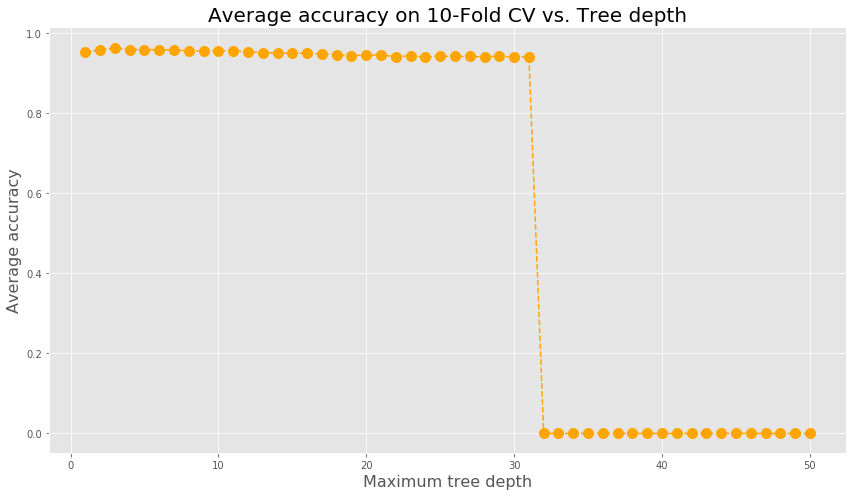

In [10]:
# Plot the results 
# Code from the lab1 solution
plt.style.use('ggplot')
plt.errorbar(range(1, maxDepth + 1), np.average(scores, axis=1), 
             color='orange', linestyle='--', marker='o', markersize=10, 
             yerr=np.std(scores, axis=1), ecolor='pink', 
             capthick=2)
plt.xlabel("Maximum tree depth", fontsize = 16)
plt.ylabel("Average accuracy", fontsize = 16)
plt.title("Average accuracy on 10-Fold CV vs. Tree depth", 
          fontsize = 20)
plt.gcf().set_size_inches(12, 7)
plt.tight_layout()
plt.savefig('img/tree1.png')

The cross validation accuracies are very high in general, however we can see that the accuracy decreases when the tree depth increases and is quite stable after depth 20. So if an accuracy above 95% is desired, an estimator from depth $3$ to $14$ is a reasonable choice for this data.          
Now I will try plotting the training and testing score with vs the depth of the tree:

In [11]:
trainging_scores = np.zeros((maxDepth, 1))
testing_scores = np.zeros((maxDepth, 1))

for depth in np.arange(1, maxDepth + 1):
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(X_train, y_train)
    trainging_scores[depth - 1] = clf.score(X_train, y_train)
    testing_scores[depth - 1] = clf.score(X_test, y_test)

KeyboardInterrupt: 

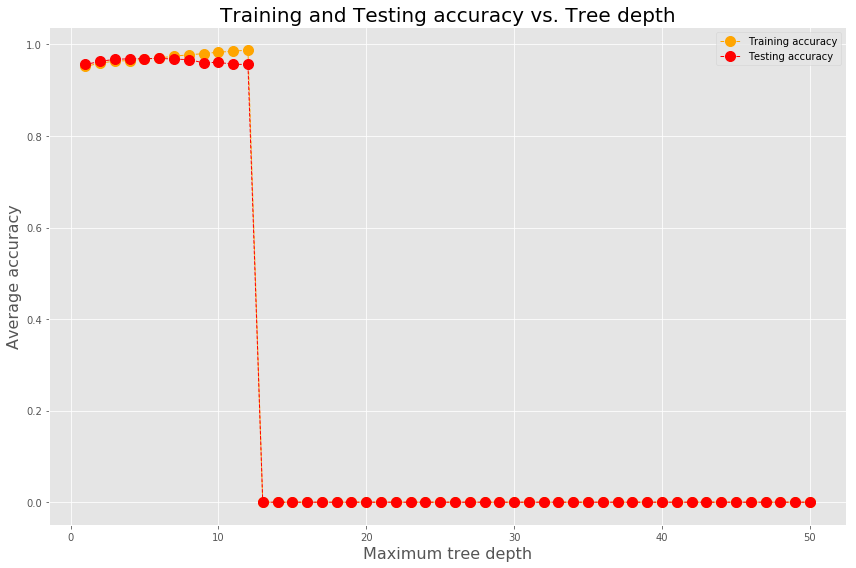

In [12]:
# Plot the results
plt.style.use('ggplot')
plt.plot(range(1, maxDepth + 1), trainging_scores, 'o--', 
         markersize=10, color='orange', lw=1, label='Training accuracy')
plt.plot(range(1, maxDepth + 1), testing_scores, 'o--',
         markersize=10, color='red', lw=1, label='Testing accuracy')
plt.xlabel("Maximum tree depth", fontsize = 16)
plt.ylabel("Average accuracy", fontsize = 16)
plt.title("Training and Testing accuracy vs. Tree depth", 
          fontsize = 20)
plt.legend(loc="best")
plt.gcf().set_size_inches(12, 8)
plt.tight_layout()
plt.savefig('img/tree2.png')

This is a much more interesting graph. It can be seen that after depth $20$, the model is definitely overfitting. However, the accuracies are relatively high for both training and testing accuracy from the very beginning, so depth from $1$ to $15$ is advisable. Now I will create the model with the parameter chosen from the test above.

In [13]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)
print("Training score of Decision Tree Classifier is",clf.score(X_train, y_train))
print("Testing score of Decision Tree Classifier is",clf.score(X_test, y_test))

Training score of Decision Tree Classifier is 0.963699119257
Testing score of Decision Tree Classifier is 0.967634459781


### Last try out: A simple ordinary least squares model.

This model will help me see which features is more significant in the dataset by the p-value.

In [14]:
import statsmodels.api as sm
lm = sm.OLS(y_train,X_train).fit()
print(lm.summary())

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


KeyboardInterrupt: 

In [15]:
plt.rc('figure', figsize=(7, 15))
plt.text(0.01, 0.05, str(lm.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('img/feature_table.png')

NameError: name 'lm' is not defined